In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sc_stats
import tabulate

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})

## Function declarations

### Read `ods` to `DataFrame`


In [3]:
def read_ods(filename, columns=None):
  if columns is None:
    df = pd.read_excel(filename, engine="odf", header=0)
  else:
    key_arr = (k for k in columns.keys())
    df = pd.read_excel(filename, engine="odf", header=0,
                       vusecols=columns)
    df = df.rename(columns=columns)
  return df

### Get linear regression coefficients ($b_0$ and $b_1$)

In [4]:
def get_regress_coeff(df):
  df["XY"] = df['X'] * df['Y']
  df["X^2"] = df['X']**2

  n = len(df)
  sumXY = df["XY"].sum()
  sumX = df["X"].sum()
  sumY = df["Y"].sum()
  sumXsq = df["X^2"].sum()

  b1 = (n*sumXY - sumX*sumY) / (n*sumXsq - sumX**2)
  b0 = sumY/n - b1*sumX/n

  # print(f"(b0, b1) = ({b0:.2f}, {b1:.2f})")
  return [b0, b1], df


### Get ANOVA table

In [5]:
def get_ANOVA_table(df):
  [b0, b1], df_residual = get_regress_coeff(df)

  # calculation sum of squares total
  df_residual["meanY"] = df_residual['Y'].mean()
  df_residual["(Y - meanY)"] = df_residual['Y'] - df_residual["meanY"]
  df_residual["(Y - meanY)^2"] = df_residual['(Y - meanY)']**2

  # calculation sum of squares error
  df_residual['hat_Y'] = b0 + b1*df_residual['X']
  df_residual['(Y - hat_Y)'] = df_residual['Y'] - df_residual["hat_Y"]
  df_residual['(Y - hat_Y)^2'] = df_residual['(Y - hat_Y)']**2

  # calculation sum of squares regression
  df_residual['(hat_Y - meanY)^2'] = (df_residual['hat_Y'] - df_residual['meanY'])**2

  SST = df_residual["(Y - meanY)^2"].sum()
  SSE = df_residual["(Y - hat_Y)^2"].sum()
  SSR = df_residual["(hat_Y - meanY)^2"].sum()

  num_of_sample = len(df_residual)

  data = [
    ["Regression", SSR, 1                , SSR/1],
    ["Error"     , SSE, num_of_sample - 2, SSE/(num_of_sample - 2)],
    ["Total"     , SST, num_of_sample - 1, None]]
  anova_table = tabulate.tabulate(data, tablefmt='html', 
    headers=["Source", "Sum of Squares", "d.o.f", "Mean Square"], 
    floatfmt=(None, ".2f", None, ".2f"))


  return anova_table, df_residual, [SST, SSR, SSE] 

## Load the data

In [7]:
filename = "05-table-11-life-expectancy.ods"

df = read_ods(filename)

df.head()

,Year,Life Expectancy,is_interpolated?
0,1970,70.8,No
1,1971,71.2,Yes
2,1972,71.5,Yes
3,1973,71.9,Yes
4,1974,72.4,Yes


## Fitted line plot

In [12]:
df_fit = pd.DataFrame()

t_year = np.arange(1, len(df)+1)
df_fit["X"] = t_year
df_fit["Y"] = df["Life Expectancy"]

# compute fitted regression line
[b0, b1], _ = get_regress_coeff(df_fit)

# compute coefficient of determination
_, _, [SST, SSR, SSE] = get_ANOVA_table(df_fit)
rSq = SSR/SST

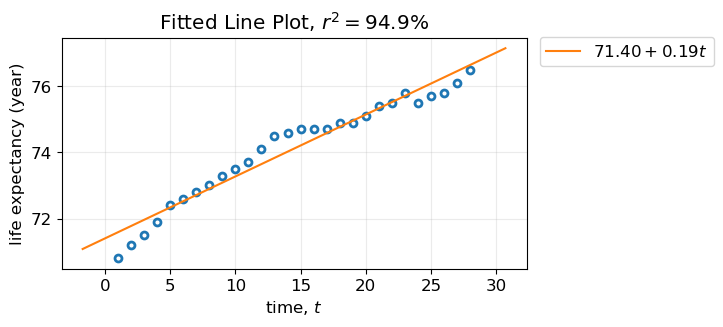

In [14]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df_fit["X"], df_fit["Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

data_t_min = df_fit["X"].min()
data_t_max = df_fit["X"].max()
t_offset = 0.1*(data_t_max - data_t_min)
t_regress = np.linspace(data_t_min - t_offset, data_t_max + t_offset)
regress_label = r"${:.2f} + {:.2f}t$".format(b0, b1) \
  if b1 > 0 else r"${:.2f}{:.2f}t$".format(b0, b1)

ax.plot(t_regress, b0 + b1*t_regress, 
  linestyle='-',
  label=regress_label) 

ax.set_xlabel(r"time, $t$")
ax.set_ylabel(r"life expectancy (year)")
ax.set_title(r"Fitted Line Plot, $r^2={:.1f}$%".format(rSq*100))

ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)


## Forecast at year 2050

In [16]:
t_forecast = (2050-df["Year"].iloc[-1]) + df_fit['X'].iloc[-1]
hat_Y_at_point = b0 + b1*t_forecast

print(f"hat_Y (t = 2050) = {hat_Y_at_point:.1f} years")

hat_Y (t = 2050) = 86.6 years
